# Load and preprocess dataset

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CTU13-GraphFrames") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


print("Spark session is ready!")


Spark session is ready!


In [2]:
df = spark.read.csv("capture20110810.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- StartTime: string (nullable = true)
 |-- Dur: double (nullable = true)
 |-- Proto: string (nullable = true)
 |-- SrcAddr: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Dir: string (nullable = true)
 |-- DstAddr: string (nullable = true)
 |-- Dport: string (nullable = true)
 |-- State: string (nullable = true)
 |-- sTos: integer (nullable = true)
 |-- dTos: integer (nullable = true)
 |-- TotPkts: integer (nullable = true)
 |-- TotBytes: long (nullable = true)
 |-- SrcBytes: long (nullable = true)
 |-- Label: string (nullable = true)

+--------------------+-----------+-----+-------------+-----+-----+-------------+-----+-----+----+----+-------+--------+--------+--------------------+
|           StartTime|        Dur|Proto|      SrcAddr|Sport|  Dir|      DstAddr|Dport|State|sTos|dTos|TotPkts|TotBytes|SrcBytes|               Label|
+--------------------+-----------+-----+-------------+-----+-----+-------------+-----+-----+----+----+-------+--------+--------+--

In [3]:
from pyspark.sql.functions import when, col, trim

# 2. Simplify Label column
df = df.withColumn(
    "LabelSimple",
    when(col("Label").contains("Botnet"), "Botnet")
    .when(col("Label").contains("Normal"), "Normal")
    .when(col("Label").contains("Background"), "Background")
    .otherwise("Unknown")
)

# 3. (Optional) clean Dir column - trim whitespace
df = df.withColumn("Dir", trim(col("Dir")))

# 4. Show sample
df.select("SrcAddr", "DstAddr", "Dir", "Label", "LabelSimple").show(10)

# 5. Check class counts
df.groupBy("LabelSimple").count().show()

+---------------+-------------+---+--------------------+-----------+
|        SrcAddr|      DstAddr|Dir|               Label|LabelSimple|
+---------------+-------------+---+--------------------+-----------+
|  212.50.71.179|147.32.84.229|<->|flow=Background-U...| Background|
|  84.13.246.132|147.32.84.229|<->|flow=Background-U...| Background|
|  217.163.21.35|147.32.86.194|<?>|     flow=Background| Background|
|     83.3.77.74|  147.32.85.5|<?>|     flow=Background| Background|
|  74.89.223.204|147.32.84.229|<->|flow=Background-U...| Background|
| 66.169.184.207|147.32.84.229|<?>|     flow=Background| Background|
|182.239.167.121|147.32.84.229|<->|flow=Background-U...| Background|
|    147.32.3.93| 147.32.84.59|<?>|flow=Background-E...| Background|
|  24.117.206.20|147.32.84.229|<->|flow=Background-U...| Background|
|   94.208.78.74|147.32.84.229|<?>|     flow=Background| Background|
+---------------+-------------+---+--------------------+-----------+
only showing top 10 rows

+-------

# Build the graph vertices and edges

In [4]:
# Create vertices DataFrame: distinct IPs as "id"
src_vertices = df.select(col("SrcAddr").alias("id"))
dst_vertices = df.select(col("DstAddr").alias("id"))
vertices = src_vertices.union(dst_vertices).distinct()

print(f"Total vertices (unique IPs): {vertices.count()}")

# Create edges DataFrame: source, destination, and features
edges = df.select(
    col("SrcAddr").alias("src"),
    col("DstAddr").alias("dst"),
    "Dir",
    "TotPkts",
    "TotBytes",
    "Dur",
    "LabelSimple"
)

print(f"Total edges (flows): {edges.count()}")

# Show samples
vertices.show(5)
edges.show(5)


Total vertices (unique IPs): 607565
Total edges (flows): 2824636
+---------------+
|             id|
+---------------+
|   79.47.168.89|
|  175.145.89.85|
|  78.26.213.255|
| 200.110.34.192|
|113.119.179.107|
+---------------+
only showing top 5 rows

+-------------+-------------+---+-------+--------+-----------+-----------+
|          src|          dst|Dir|TotPkts|TotBytes|        Dur|LabelSimple|
+-------------+-------------+---+-------+--------+-----------+-----------+
|212.50.71.179|147.32.84.229|<->|     12|     875|3550.182373| Background|
|84.13.246.132|147.32.84.229|<->|      2|     135|    8.83E-4| Background|
|217.163.21.35|147.32.86.194|<?>|      2|     120|    3.26E-4| Background|
|   83.3.77.74|  147.32.85.5|<?>|      3|     180|   0.056966| Background|
|74.89.223.204|147.32.84.229|<->|     42|    2856|3427.768066| Background|
+-------------+-------------+---+-------+--------+-----------+-----------+
only showing top 5 rows



# Build GraphFrame and calculate graph features

In [5]:
from graphframes import GraphFrame

# Create GraphFrame
g = GraphFrame(vertices, edges)

# Degree (number of edges for each node)
degree_df = g.degrees

# PageRank (importance score)
pr_results = g.pageRank(resetProbability=0.15, maxIter=5)
pagerank_df = pr_results.vertices.select("id", "pagerank")

# Merge degree and pagerank
features_df = degree_df.join(pagerank_df, on="id", how="outer").fillna(0)

# Show results
features_df.show(20)

/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/spark/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------------+------+------------------+
|           id|degree|          pagerank|
+-------------+------+------------------+
|    1.11.9.68|     1|0.2649998684189333|
|   1.112.1.75|     1|0.2649998684189333|
|1.112.194.162|     1|0.2649998684189333|
|  1.112.61.49|     2|0.2649998684189333|
| 1.112.84.202|     1|0.2649998684189333|
| 1.114.18.255|     1|0.2649998684189333|
|1.114.182.185|     1|0.2649998684189333|
| 1.114.39.141|     1|0.2649998684189333|
|1.115.114.142|     1|0.2649998684189333|
|  1.115.16.31|     1|0.2649998684189333|
| 1.115.20.181|     1|0.2649998684189333|
| 1.115.41.235|     4|0.2649998684189333|
|  1.115.86.49|     1|0.2649998684189333|
|1.126.227.134|     1|0.2649998684189333|
|1.144.212.222|     1|0.2649998684189333|
|1.144.240.115|     1|0.2649998684189333|
| 1.144.66.157|     1|0.2649998684189333|
| 1.144.92.135|     1|0.2649998684189333|
|1.148.137.214|     1|0.2649998684189333|
|1.148.158.169|     1|0.2649998684189333|
+-------------+------+------------

In [6]:
features_df.orderBy("degree", ascending=False).show(20)
features_df.orderBy("pagerank", ascending=False).show(20)

+--------------+-------+------------------+
|            id| degree|          pagerank|
+--------------+-------+------------------+
| 147.32.84.229|1205453| 281911.6059763415|
|   147.32.80.9| 962879|  2453.00261124487|
| 147.32.84.138| 530947| 260.3953698073445|
|  147.32.84.59| 278121| 2176.858099329223|
| 147.32.85.100|  66941|105.53609275826174|
|   70.37.98.60|  64001|0.2649998684189333|
|  147.32.85.25|  44954|32.074195954051206|
| 147.32.84.165|  41270|18.367273310788168|
|  147.32.85.34|  37155| 45.77943988526621|
| 147.32.85.124|  32890|2780.4075977826337|
|  147.32.86.20|  30621|0.8316268390793408|
| 147.32.84.171|  29580|199.71036938450374|
| 147.32.86.194|  20369| 1064.948222559075|
|  147.32.80.13|  20050| 387.6110669443682|
| 147.32.84.170|  18471|1.3744038911363414|
|  147.32.86.99|  12984|142.29167627715552|
|   147.32.85.7|  11995|1.2953898451606114|
|111.221.102.89|  11177|2.3140402320645137|
|188.205.231.61|  11010|0.6076637755919994|
| 147.32.86.187|  10504|  88.965

In [7]:
features_df.filter(col("degree") > 10).orderBy("degree", ascending=True).show(20)

+---------------+------+------------------+
|             id|degree|          pagerank|
+---------------+------+------------------+
| 130.88.253.235|    11|0.3276021766737082|
|  124.9.193.192|    11|0.3081392506353116|
|  125.63.74.104|    11|0.2649998684189333|
| 190.25.220.116|    11|0.2649998684189333|
| 125.230.131.37|    11|2.2102342384119584|
| 128.178.114.65|    11|0.2649998684189333|
|  193.68.35.136|    11| 0.324745687399268|
|  109.95.30.253|    11| 5.048410128349964|
|  126.163.72.75|    11|0.2649998684189333|
|  14.102.15.201|    11|0.2649998684189333|
| 128.32.251.121|    11| 4.187126727753384|
| 110.165.222.99|    11|1.2546904102122027|
| 195.199.197.37|    11|0.3105288198769514|
|   141.2.55.214|    11|   3.1348733756968|
|124.186.198.222|    11|0.2649998684189333|
|  114.24.142.20|    11| 5.042719009417711|
|  115.111.218.6|    11|0.2649998684189333|
| 141.30.211.176|    11|0.2649998684189333|
|135.196.102.220|    11|0.2649998684189333|
| 114.34.109.192|    11| 1.24177

# check what these IPs actually are

I want to see if these IPs with high degree and pagerank, mostly occur in "Botnet" labeled flows, "Background", or "Normal".

In [8]:
# Pick top IPs to analyze
top_ips = [row['id'] for row in features_df.orderBy(col("degree").desc()).limit(20).collect()]

print(top_ips)

# Filter edges where src or dst in top_ips
filtered_edges = edges.filter(
    (col("src").isin(top_ips)) | (col("dst").isin(top_ips))
)

# Count label distribution
label_counts = filtered_edges.groupBy("LabelSimple").count()
label_counts.show(truncate=False)


['147.32.84.229', '147.32.80.9', '147.32.84.138', '147.32.84.59', '147.32.85.100', '70.37.98.60', '147.32.85.25', '147.32.84.165', '147.32.85.34', '147.32.85.124', '147.32.86.20', '147.32.84.171', '147.32.86.194', '147.32.80.13', '147.32.84.170', '147.32.86.99', '147.32.85.7', '111.221.102.89', '188.205.231.61', '147.32.86.187']
+-----------+-------+
|LabelSimple|count  |
+-----------+-------+
|Background |2523280|
|Normal     |27121  |
|Botnet     |40961  |
+-----------+-------+



Original data based on labels:

**we can see that these 20 IPs appeard in all of the Botnet connections while they appear in almost 90% of the Background and Normal connections.**

| LabelSimple |  count  |
|-------------|---------|
| Background  | 2753288 |
| Normal      |   30387 |
| Botnet      |   40961 |

* These 20 IPs are involved in all botnet flows — meaning they either sent to or received from these flows.
* But that doesn’t mean they are the only IPs doing botnet communication. There could be other "low degree" IPs as well, just less central.
* Big IPs act as "hubs" for all botnet traffic → they are highly suspicious.ons.**

### check flow statistics

In [9]:
from pyspark.sql.functions import avg

stats = filtered_edges.groupBy("src").agg(
    avg("TotPkts").alias("avg_packets"),
    avg("TotBytes").alias("avg_bytes"),
    avg("Dur").alias("avg_duration")
)
stats.show(truncate=False)


+---------------+------------------+------------------+---------------------+
|src            |avg_packets       |avg_bytes         |avg_duration         |
+---------------+------------------+------------------+---------------------+
|79.47.168.89   |121.5             |10822.0           |1473.768279          |
|175.145.89.85  |27.75             |7510.125          |1528.136763125       |
|78.26.213.255  |119.5             |21039.25          |3519.92791725        |
|113.119.179.107|30.0              |1980.0            |2271.650146          |
|151.55.55.208  |10.0              |1478.5            |45.798345999999995   |
|212.160.150.178|4.0               |272.0             |1899.3423169999999   |
|94.112.245.51  |3.0               |627.0             |182.902081           |
|178.177.5.134  |232.66666666666666|23466.666666666668|3084.120198666667    |
|77.76.137.219  |2.0               |137.66666666666666|0.0012616666666666668|
|129.215.127.168|12.0              |1713.0            |3489.8442

# Botnet ratio analysis

It helps us figure out how suspicious an IP is based on the proportion of its botnet-related traffic compared to all its traffic.

In [11]:
from pyspark.sql.functions import col, when, lit, sum as _sum

# 1. Extract flows for each IP as source or destination
src_df = edges.select(col("src").alias("id"), "LabelSimple")
dst_df = edges.select(col("dst").alias("id"), "LabelSimple")

# 2. Combine
all_ip_flows = src_df.union(dst_df)

# 3. Count Botnet, Normal, Background flows per IP
ip_flow_counts = all_ip_flows.groupBy("id").pivot("LabelSimple").count().fillna(0)

# 4. Calculate total flows per IP
ip_flow_counts = ip_flow_counts.withColumn(
    "TotalFlows", col("Botnet") + col("Normal") + col("Background")
)

# 5. Calculate Botnet ratio
ip_flow_counts = ip_flow_counts.withColumn(
    "BotnetRatio", col("Botnet") / col("TotalFlows")
)

# 6. Sort by BotnetRatio descending to see suspicious IPs first
ip_flow_counts.orderBy(col("BotnetRatio").desc()).show(20, False)


+--------------+----------+------+------+----------+-----------+
|id            |Background|Botnet|Normal|TotalFlows|BotnetRatio|
+--------------+----------+------+------+----------+-----------+
|199.246.162.3 |0         |1     |0     |1         |1.0        |
|195.54.209.230|0         |1     |0     |1         |1.0        |
|95.173.131.22 |0         |1     |0     |1         |1.0        |
|78.47.149.170 |0         |1     |0     |1         |1.0        |
|212.44.70.17  |0         |1     |0     |1         |1.0        |
|206.54.145.17 |0         |3     |0     |3         |1.0        |
|92.255.72.5   |0         |1     |0     |1         |1.0        |
|134.96.100.105|0         |1     |0     |1         |1.0        |
|212.48.128.30 |0         |1     |0     |1         |1.0        |
|195.34.238.53 |0         |1     |0     |1         |1.0        |
|62.58.96.132  |0         |1     |0     |1         |1.0        |
|80.84.34.78   |0         |1     |0     |1         |1.0        |
|67.19.72.206  |0        

**these IPs are likely botnet-infected hosts or botmasters.**

# Feature Engineering and Applying RandomForest 

In [12]:
from pyspark.ml.feature import StringIndexer

# Encode Protocol (Proto)
proto_indexer = StringIndexer(inputCol="Proto", outputCol="ProtoIdx").fit(df)
df = proto_indexer.transform(df)

# Encode Direction (Dir)
dir_indexer = StringIndexer(inputCol="Dir", outputCol="DirIdx").fit(df)
df = dir_indexer.transform(df)


In [16]:
# Prepare source features with renamed columns
src_features = features_df.selectExpr("id as src_id", "degree as src_degree", "pagerank as src_pagerank")

# Join source features on SrcAddr == src_id
df = df.join(src_features, df.SrcAddr == src_features.src_id, "left").drop("src_id")

# Prepare destination features with renamed columns
dst_features = features_df.selectExpr("id as dst_id", "degree as dst_degree", "pagerank as dst_pagerank")

# Join destination features on DstAddr == dst_id
df = df.join(dst_features, df.DstAddr == dst_features.dst_id, "left").drop("dst_id")


In [18]:
from pyspark.sql.functions import when, col

df = df.withColumn("label", when(col("LabelSimple") == "Botnet", 1).otherwise(0))

In [20]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# 1. Convert label to numeric index
label_indexer = StringIndexer(inputCol="LabelSimple", outputCol="labelIndex")
df = label_indexer.fit(df).transform(df)

# 2. Assemble features into a vector column
assembler = VectorAssembler(
    inputCols=["TotPkts", "TotBytes", "Dur", "src_degree", "src_pagerank", "dst_degree", "dst_pagerank"],
    outputCol="features"
)
df = assembler.transform(df)


In [22]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=50)

In [23]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees=50)
model = rf.fit(train_df)

In [24]:
predictions = model.transform(test_df)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score = {f1_score:.4f}")

Test F1 Score = 0.9810


### show classification report in Pandas

In [25]:
# Select only prediction and true label columns and convert to Pandas
pred_labels_pd = predictions.select("prediction", "labelIndex").toPandas()

In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Make sure predictions and labels are numpy arrays
y_pred = pred_labels_pd["prediction"].values
y_true = pred_labels_pd["labelIndex"].values

report = classification_report(y_true, y_pred, output_dict=True)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    824854
         1.0       1.00      0.81      0.90     12467
         2.0       0.95      0.00      0.00      9156

    accuracy                           0.99    846477
   macro avg       0.98      0.61      0.63    846477
weighted avg       0.99      0.99      0.98    846477



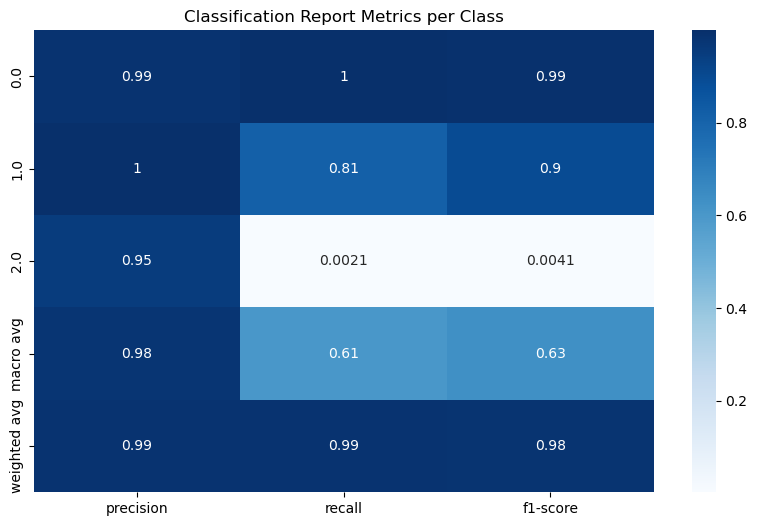

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dict to DataFrame (remove 'accuracy' entry because it’s a scalar)
report_df = pd.DataFrame(report).drop(columns=["accuracy"]).T

# Plot heatmap for precision, recall, f1-score
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap="Blues")
plt.title("Classification Report Metrics per Class")
plt.show()


The classification report shows that class 0.0 (Background) has very high precision and recall (almost perfect), meaning the model easily detects these dominant background flows. Class 1.0 (Botnet) also performs well with high precision and good recall (0.81), indicating it can identify botnet connections reasonably well, although some are still missed. However, class 2.0 (Normal) has an F1-score and recall of 0, meaning the model fails to correctly classify any Normal samples and never predicts this label. This happens because of strong class imbalance: Background samples vastly outnumber Normal and Botnet samples, causing the model to bias toward the majority class and struggle with underrepresented ones. Overall accuracy appears high (0.99), but this metric is misleading here since it is mostly driven by the dominant Background class. To improve, we should consider rebalancing the dataset (e.g., through oversampling minority classes or undersampling Background) and adding additional discriminative features to help the model better separate Normal and Botnet connections from Background traffic.